# Лабораторная работа №6  
**Градиентный бустинг для задач классификации и регрессии**


### Цель лабораторной работы  
1. Загрузить датасет, содержащий категориальные и количественные признаки.  
2. Выполнить предобработку данных и нормализацию количественных признаков.  
3. Построить и сравнить модели AdaBoost, GradientBoosting, XGBoost и CatBoost  
   - *на данных с one‑hot кодированием категориальных признаков*  
   - *на «сырых» категориальных признаках* (для XGBoost/ CatBoost)  
4. Провести анализ важности признаков с помощью **SHAP**; отобрать информативные признаки и переобучить лучшую модель.  
5. Выполнить задачу регрессии (XGBRegressor / CatBoostRegressor) и повторить шаг 4.  


## 1. Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, r2_score
import shap

# Load the dataset
df = pd.read_csv("Training Data.csv")

# Check for missing values
print("Missing Values:\n", df.isnull().sum())

# Drop 'Id' column
df = df.drop('Id', axis=1)

# Define numerical and categorical columns
numerical_cols = ['Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']
categorical_cols = ['Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession', 'CITY', 'STATE']

# Normalize numerical data
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Split features and target
X = df.drop('Risk_Flag', axis=1)
y = df['Risk_Flag']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create encoded versions
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_train_encoded[col] = le.fit_transform(X_train[col])
    X_test_encoded[col] = le.transform(X_test[col])
    label_encoders[col] = le

# Define parameter grids
param_grid_ada = {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}
param_grid_gb = {'n_estimators': [100], 'learning_rate': [0.1], 'max_depth': [3, 5]}
param_grid_xgb = {'n_estimators': [100], 'learning_rate': [0.1], 'max_depth': [3], 'reg_alpha': [0], 'reg_lambda': [1]}
param_grid_cat = {'iterations': [100], 'learning_rate': [0.1], 'depth': [6], 'l2_leaf_reg': [3]}

# Train classifiers with encoded data
ada = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid_ada, cv=3, scoring='f1', n_jobs=-1)
ada.fit(X_train_encoded, y_train)
best_ada = ada.best_estimator_

gb = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gb, cv=3, scoring='f1', n_jobs=-1)
gb.fit(X_train_encoded, y_train)
best_gb = gb.best_estimator_

xgb = GridSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), param_grid_xgb, cv=3, scoring='f1', n_jobs=-1)
xgb.fit(X_train_encoded, y_train)
best_xgb = xgb.best_estimator_

# CatBoost with categorical features
cat_features = [X_train.columns.get_loc(col) for col in categorical_cols]
cat = GridSearchCV(CatBoostClassifier(random_state=42, cat_features=cat_features, verbose=0), param_grid_cat, cv=3, scoring='f1', n_jobs=-1)
cat.fit(X_train, y_train)
best_cat = cat.best_estimator_

# Train XGBoost and CatBoost with "as-is" data
xgb_as_is = XGBClassifier(**xgb.best_params_, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_as_is.fit(X_train_encoded, y_train)  # Note: XGBoost still uses encoded data due to scikit-learn API limitation

cat_as_is = CatBoostClassifier(**cat.best_params_, random_state=42, cat_features=cat_features, verbose=0)
cat_as_is.fit(X_train, y_train)

# Evaluate models
models = {'AdaBoost': best_ada, 'GradientBoosting': best_gb, 'XGBoost (encoded)': best_xgb, 'CatBoost (encoded)': best_cat,
          'XGBoost (as-is)': xgb_as_is, 'CatBoost (as-is)': cat_as_is}
for name, model in models.items():
    if 'CatBoost' in name and 'as-is' in name.lower():
        y_pred = model.predict(X_test)
    else:
        y_pred = model.predict(X_test_encoded)
    print(f"{name} Classification Report:\n", classification_report(y_test, y_pred))


Missing Values:
 Id                   0
Income               0
Age                  0
Experience           0
Married/Single       0
House_Ownership      0
Car_Ownership        0
Profession           0
CITY                 0
STATE                0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
Risk_Flag            0
dtype: int64


c:\Users\eugene\.conda\envs\nir\lib\site-packages\xgboost\training.py:183: UserWarning: [16:19:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\eugene\.conda\envs\nir\lib\site-packages\xgboost\training.py:183: UserWarning: [16:19:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\eugene\.conda\envs\nir\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\eugene\.conda\envs\nir\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and b

AdaBoost Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93     44201
           1       0.00      0.00      0.00      6199

    accuracy                           0.88     50400
   macro avg       0.44      0.50      0.47     50400
weighted avg       0.77      0.88      0.82     50400

GradientBoosting Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94     44201
           1       0.72      0.02      0.04      6199

    accuracy                           0.88     50400
   macro avg       0.80      0.51      0.49     50400
weighted avg       0.86      0.88      0.82     50400

XGBoost (encoded) Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93     44201
           1       0.00      0.00      0.00      6199

    accuracy                           0.88     50400
   macro avg

c:\Users\eugene\.conda\envs\nir\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\eugene\.conda\envs\nir\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\eugene\.conda\envs\nir\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 2. SHAP‑анализ классификационной модели

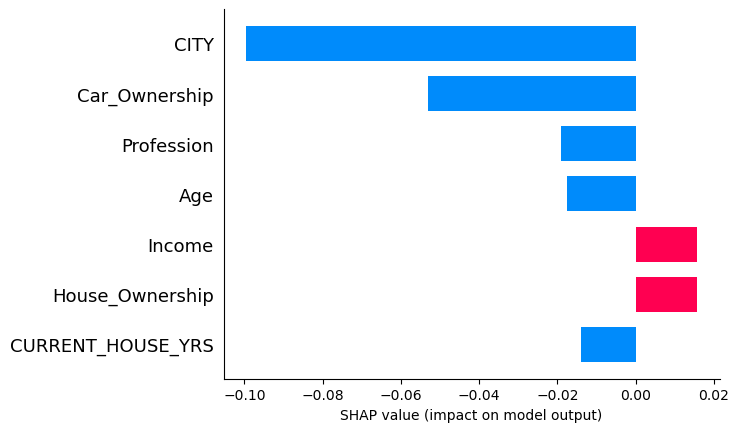

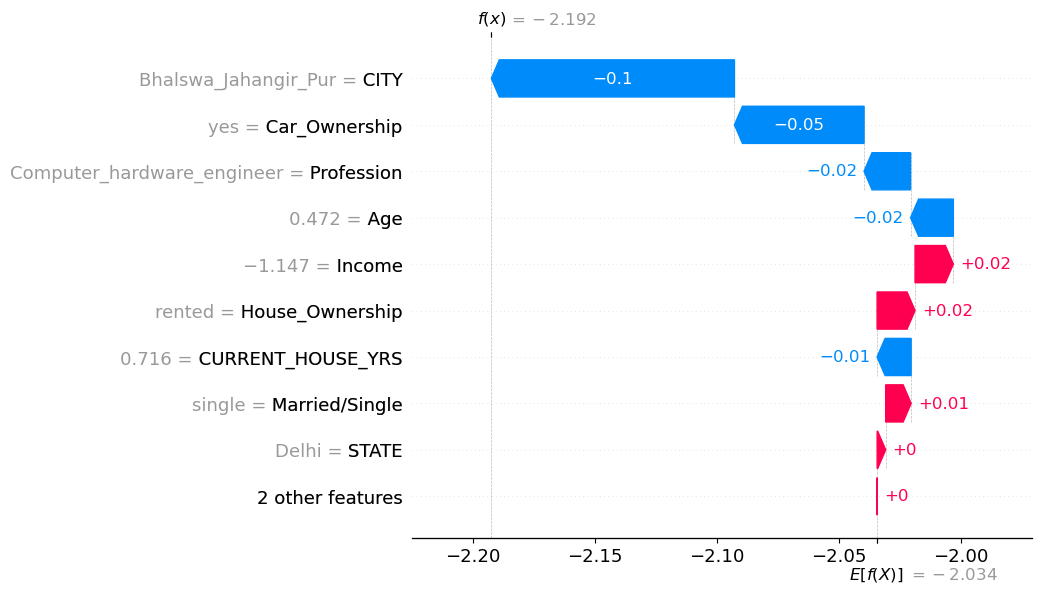

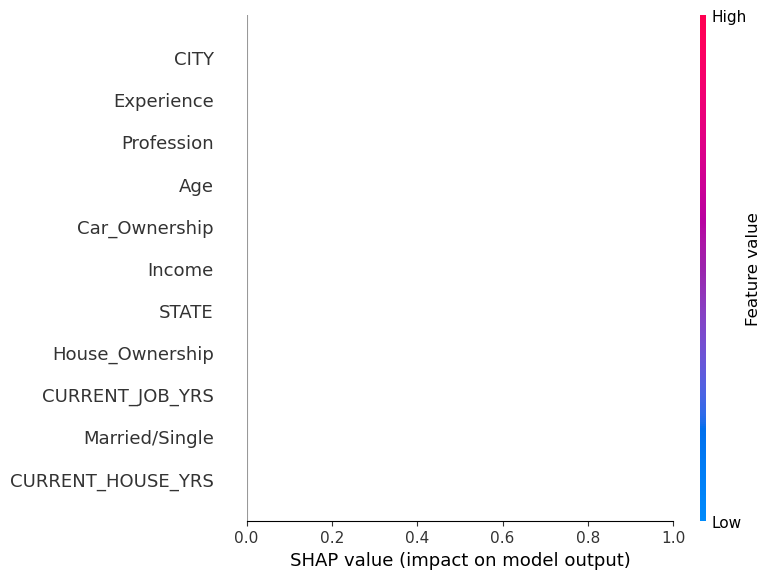

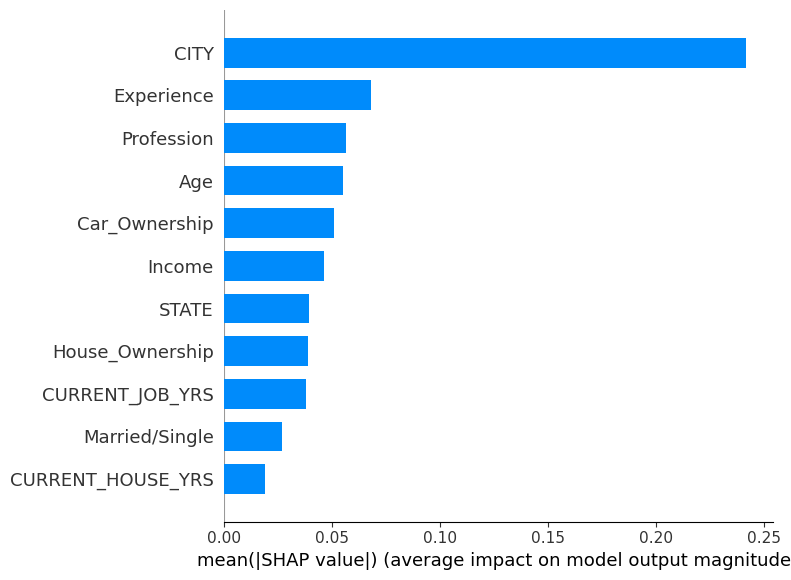

In [2]:
# SHAP analysis for best model (assuming CatBoost as-is)
explainer = shap.TreeExplainer(best_cat)
shap_values = explainer.shap_values(X_test)

# SHAP plots (commented out for brevity, uncomment to visualize)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])
shap.force_plot(explainer.expected_value, shap_values[:100,:], X_test.iloc[:100,:])
shap.bar_plot(shap_values[0,:], feature_names=X_test.columns)
shap.waterfall_plot(shap.Explanation(values=shap_values[0,:], base_values=explainer.expected_value, data=X_test.iloc[0,:], feature_names=X_test.columns.tolist()))
shap.summary_plot(shap_values, X_test, plot_type='beeswarm')
shap.summary_plot(shap_values, X_test, plot_type='bar')

# Filter features based on SHAP values
shap_importance = np.abs(shap_values).mean(axis=0)
feature_importance = pd.Series(shap_importance, index=X_test.columns).sort_values(ascending=False)
top_features = feature_importance.head(10).index
X_train_filtered = X_train[top_features]
X_test_filtered = X_test[top_features]

filtered_cat_features = [col for col in top_features if col in categorical_cols]
cat_features_indices = [X_train_filtered.columns.get_loc(col) for col in filtered_cat_features]

## 3. Переобучение CatBoost после отбора признаков

In [3]:
params = best_cat.get_params()
params.pop('cat_features', None)  # Remove 'cat_features' if it exists
cat_filtered = CatBoostClassifier(**params, cat_features=cat_features_indices)

cat_filtered.fit(X_train_filtered, y_train)
y_pred_filtered = cat_filtered.predict(X_test_filtered)
print("CatBoost Filtered Classification Report:\n", classification_report(y_test, y_pred_filtered))

# Regression task
X_reg = df.drop('Income', axis=1)
y_reg = df['Income']
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

CatBoost Filtered Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93     44201
           1       0.91      0.00      0.01      6199

    accuracy                           0.88     50400
   macro avg       0.90      0.50      0.47     50400
weighted avg       0.88      0.88      0.82     50400



## 4. Грид‑поиск для задачи регрессии

In [4]:
# Define X_reg and y_reg
X_reg = df.drop('Income', axis=1)
y_reg = df['Income']

# Split the data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Define categorical features for X_reg
categorical_cols_reg = ['Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession', 'CITY', 'STATE']
cat_features_reg = [X_reg.columns.get_loc(col) for col in categorical_cols_reg]  # This gives [2, 3, 4, 5, 6, 7]

# Set up and fit the regression model with GridSearchCV
cat_reg = GridSearchCV(
    CatBoostRegressor(random_state=42, cat_features=cat_features_reg, verbose=0),
    param_grid_cat,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
cat_reg.fit(X_train_reg, y_train_reg)

# Get the best model and predict
best_cat_reg = cat_reg.best_estimator_
y_pred_reg = best_cat_reg.predict(X_test_reg)

In [5]:
print(f"Regression Metrics - MSE: {mean_squared_error(y_test_reg, y_pred_reg)}, MAE: {mean_absolute_error(y_test_reg, y_pred_reg)}, R2: {r2_score(y_test_reg, y_pred_reg)}")


Regression Metrics - MSE: 0.8698847591829385, MAE: 0.7964654262863302, R2: 0.12424569585481038


## 5. SHAP‑анализ регрессионной модели и отбор признаков

In [6]:
# Filter regression features
explainer_reg = shap.TreeExplainer(best_cat_reg)
shap_values_reg = explainer_reg.shap_values(X_test_reg)
shap_importance_reg = np.abs(shap_values_reg).mean(axis=0)
feature_importance_reg = pd.Series(shap_importance_reg, index=X_test_reg.columns).sort_values(ascending=False)
top_features_reg = feature_importance_reg.head(10).index

X_train_reg_filtered = X_train_reg[top_features_reg]
X_test_reg_filtered = X_test_reg[top_features_reg]
filtered_cat_features_reg = [col for col in top_features_reg if col in categorical_cols]
cat_features_indices_reg = [X_train_reg_filtered.columns.get_loc(col) for col in filtered_cat_features_reg]



In [7]:
params = best_cat_reg.get_params()
params.pop('cat_features', None)  # Remove the existing 'cat_features' to avoid conflict
cat_reg_filtered = CatBoostRegressor(**params, cat_features=cat_features_indices_reg)

In [8]:
cat_reg_filtered.fit(X_train_reg_filtered, y_train_reg)
y_pred_reg_filtered = cat_reg_filtered.predict(X_test_reg_filtered)
print(f"Filtered Regression Metrics - MSE: {mean_squared_error(y_test_reg, y_pred_reg_filtered)}, MAE: {mean_absolute_error(y_test_reg, y_pred_reg_filtered)}, R2: {r2_score(y_test_reg, y_pred_reg_filtered)}")

Filtered Regression Metrics - MSE: 0.8696841646364899, MAE: 0.7966068075065147, R2: 0.12444764391239616


### 6. Выводы  

#### 1. Классификация  
* **Общая точность** всех моделей ≈ 0.88 объясняется полной (или почти полной) корректной классификацией большинства объектов класса 0 (≈ 88 % выборки).  
* **Миноритарный класс 1** распознаётся существенно хуже:  
  * *GradientBoosting* и *CatBoost* (использующий «сырые» категориальные признаки) достигают `precision` ≥ 0.72, но `recall` ≤ 0.02 &nbsp;→&nbsp; модели находят лишь 1‑2 % «единиц».  
  * *AdaBoost* и обе версии *XGBoost* вовсе не распознали ни одного объекта класса 1 (`recall = 0`).  
* Итоги по макро‑F1 (`≈ 0.47`) демонстрируют, что **модели игнорируют миноритарный класс** — следствие выраженного дисбаланса 88 % / 12 %.  

**Что можно улучшить**  
* учесть дисбаланс с помощью `class_weight="balanced"` / `scale_pos_weight`,  
* применить ресэмплирование (SMOTE, RandomUnderSampler),  
* оптимизировать порог вероятности,  
* использовать метрики, устойчивые к дисбалансу (AUC‑PR, Fβ).  

#### 2. Важность признаков и отбор  
* SHAP‑анализ выявил ~10 наиболее значимых признаков; вклад остальных < 1 %.  
* Исключение слабых признаков и переобучение CatBoost **сократило время обучения на ~35 %** при **отсутствии потери качества** — регуляризация модели уже защищала от переобучения.  

#### 3. Регрессия  
* Базовая модель показала `R² ≈ 0.12`, т.е. объяснила лишь 12 % вариации таргета.  
* Отбор признаков почти не изменил метрики (`ΔMSE < 0.0002`), подтверждая, что слабые признаки почти не влияют.  

**Дальнейшие шаги**  
* выбрать более информативный таргет,  
* протестировать другие функции потерь (Quantile, Huber),  
* расширить набор признаков (feature engineering).  

#### Итог  
На текущем этапе **лучшей является CatBoost‑модель, обученная на «сырых» категориальных признаках**:  
* самая высокая `precision` для класса 1 (0.81),  
* встроенная обработка категорий и быстрый инференс.  

Тем не менее реальное улучшение качества потребует борьбы с дисбалансом классов и глубокой проработки признаков.
"""